In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.interpolate import griddata
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mplc
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
%matplotlib inline
import seaborn as sns
import random
import pyreadr
import requests
import re
import xarray as xr
import rasterio


# import descartes
import geopandas as gpd
import geodatasets
from shapely.geometry import Point, Polygon, LineString
import shapely.geometry
import osmnx as ox #openstreet map
import pickle

import folium

%matplotlib inline

import networkx as nx
import collections

import rioxarray

import netCDF4
from netCDF4 import num2date


import warnings
warnings.filterwarnings('ignore')


import os

In [2]:
#STEP RESOLUTION DEGREES TO meters

from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):

    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371000 # Radius of earth in meters
    return c * r 

haversine(10,10,10.01,10)

1095.0562585100474

# INFORMATION

In [3]:
temperature = 'mean'
PM = '25'
size = '1000'

# CITIES

In [49]:

cities = [

    'Barcelona', 'Montpellier', 'Rome', 'Naples', 'Porto', 'Sevilla', 'Alicante', 'Valencia', 'Bologna', 'Padua', 'Turin',
    'Madrid', 'Murcia', 'Genoa', 'Milan', 'Lisbon', 'Palma_de_Mallorca', 'Split','Marseille', 'Palermo','Nice', 'Malaga', 'Bari',

    'Antwerp', 'Amsterdam', 'Brussels', 'London', 'Paris', 'Luxembourg', 'Rotterdam', 'Lille', 'Basel', 'Birmingham', 'Nantes', 'Strasbourg',
    'Zurich', 'Frankfurt', 'Vienna', 'Munich', 'Bratislava', 'Prague', 'Geneva', 'Bordeaux', 'Utrecht', 
    'Liege', 'Bilbao', 'Charleroi', 'Wroclaw', 'Leipzig', 'Berlin', 'Hamburg', 'Lodz', 'Warsaw', 'Edinburgh', 
    'Glasgow', 'Cologne', 'Dusseldorf', 'Newcastle', 'Ghent', 'Dublin', 'Toulouse', 'Leeds', 'Lyon',

    'Tallinn','Reykjavik', 'Copenhagen', 'Goteborg', 'Helsinki', 'Stockholm', 'Oslo', 'Tartu', 'Riga', 'Klaipeda', 'Vilnius', 'Gdansk',

    'Sofia', 'Zagreb', 'Budapest', 'Szeged', 'Brasov', 'Bucharest', 'Ljubljana', 'Sarajevo', 'Gyor','Thessaloniki','Debrecen','Belgrado', 'Podgorica',
    'Trieste', 'Miskolc', 'Kosice', 'Krakow', 'Pecs', 'Varna', 'Skopje', 'Novi_Sad', 'Graz', 'Athens', 'Tirana', 'Cluj_Napoca',

    'Accra', 'Addis_Abeba', 'Amman', 'Auckland', 'Bogota', 'Buenos_Aires', 'Cairo', 'Cape_Town', 'Chennai', 'Curitiba', 'Dakar', 'Dhaka', 'Dubai', 
    'Ho_Chi_Minh', 'Hong_Kong', 'Houston', 'Islamabad', 'Istanbul', 'Jakarta', 'Karachi', 'Lagos', 'Lima', 'Los_Angeles', 'Marrakesh', 'Medina', 
    'Melbourne', 'Mexico_City', 'Mogadishu', 'Moscow', 'Nairobi', 'Nanjing', 'New_York', 'Phoenix', 'Rabat', 'Salvador', 'Santiago', 'Singapore', 
    'Sydney', 'Teheran', 'Tokyo', 'Toronto', 'Tschwane'
]

# AIR TEMPERATURE - UrbClim

In [5]:
# Base folder where you want to store the datasets per city
base_output_dir = r"C:\Users\mduran\Desktop\PhD- Patterns and Dynamics in Urban Networks\1- DATA POLLUTION - Scaling laws, pdfs\TEMPERATURE\UrbClim_100m\datasets_GLOBAL"

T_dic = {}

for city in cities:
    # Create a city-specific output directory
    output_dir = os.path.join(base_output_dir, city)
    os.makedirs(output_dir, exist_ok=True)

    
    # -------------------------------
    # Stage 1: Download the UrbClim NetCDF File for the city
    # -------------------------------
    '''
    url = "https://provide.marvin.vito.be/ftp/compressed_daily/" + city + "/"
    
    response = requests.get(url)
    if response.status_code == 200:
        # Use regex to find all .nc file links in the directory listing
        file_links = re.findall(r'href="(.*?\.nc)"', response.text)
        print(f"{city}: Found files:", file_links)
        # We are interested in the file named "T2M_year_daily_mean_2017.nc"
        target_file = "T2M_year_daily_mean_2015.nc"
        if target_file in file_links:
            full_url = url + target_file
            print(f"{city}: Downloading {full_url}")
            file_response = requests.get(full_url)
            output_path = os.path.join(output_dir, target_file)
            with open(output_path, 'wb') as f:
                f.write(file_response.content)
            print(f"{city}: Downloaded and saved to {output_path}")
        else:
            print(f"{city}: {target_file} not found on the server.")
    else:
        print(f"{city}: Failed to fetch directory listing: {response.status_code}")
    '''
    # -------------------------------
    # Stage 2: Open and Process the NetCDF File
    # -------------------------------
    
    target_file = "T2M_year_daily_mean_2017.nc"
    
    nc_path = os.path.join(output_dir, target_file)
    ds = xr.open_dataset(nc_path)
    # Inspect the dataset if needed:
    # print(f"{city}: Dataset info:")
    # print(ds)
    
    # Reproject the data since crs is in local projection
    local_crs = ds.attrs.get("crs")
    # print(local_crs)
    ds['T2M'] = ds['T2M'].rio.write_crs(local_crs, inplace=False)
    
    tas_4326 = ds['T2M'].rio.reproject("EPSG:4326")
    
    # Compute the annual mean over time (average of all 365 days)
    annual_mean = tas_4326.mean(dim="time")
    
    # Convert the resulting DataArray to a DataFrame.
    df = annual_mean.to_dataframe(name="T").reset_index()
    if "longitude" in df.columns and "latitude" in df.columns:
        df = df.rename(columns={"longitude": "x", "latitude": "y"})
    
    # Store the DataFrame in the dictionary keyed by city
    T_dic[city] = df
    

# DEFINING CITY BOX

In [7]:
# based on the temperature data domain

xmin = {}
xmax = {}
ymin = {}
ymax = {}

for city in cities:
    
    xmin[city], ymin[city] = min(T_dic[city].x), min(T_dic[city].y) 
    xmax[city], ymax[city] = max(T_dic[city].x), max(T_dic[city].y)

# MAX LAND SURFACE TEMPERATURE (LST)

In [10]:
temperature = 'max_LST'

In [12]:
os.chdir(r'C:\Users\mduran\Desktop\PhD- Patterns and Dynamics in Urban Networks\1- DATA POLLUTION - Scaling laws, pdfs\TEMPERATURE\Columbia_LST_1km')

xds = rioxarray.open_rasterio('sdei-global-summer-lst-2013-day-max-global.tif',masked=True)

In [13]:
xdsc_dic = {}
T_dic = {}

for city in cities:

    xdsc_dic[city] = xds.rio.clip_box(
        xmin[city],
        ymin[city],
        xmax[city],
        ymax[city],
    )
    
    xdsc_dic[city].name = "T"

    xdsc_dic[city] = xdsc_dic[city].squeeze().drop_vars('spatial_ref').drop_vars("band")

    T_dic[city] = xdsc_dic[city].to_dataframe().reset_index()

In [14]:
# Celsius a Kelvin

for city in cities:
    T_dic[city]['T'] = T_dic[city]['T']+ 273.15

# STREET NETWORK

In [8]:
#OPEN STREET NETWORK

os.chdir(r'C:\Users\mduran\Desktop\PhD- Patterns and Dynamics in Urban Networks\1- DATA POLLUTION - Scaling laws, pdfs\street_network\dataframes')

net_type = 'drive'

NETWORK_node_dic = {}
pos_dic = {}

for city in cities:
    
    NETWORK = pickle.load(open(city+'_NETWORK_'+net_type, 'rb'))
    pos_ = {}
    
    for n in NETWORK.nodes:
        pos_[n] = [NETWORK.nodes('x')[n],NETWORK.nodes('y')[n]]
    pos_dic[city] = pos_

    pos_arr = np.array([pos_dic[city][x] for x in pos_dic[city].keys()])

    NETWORK_node_dic[city] = pd.DataFrame(index=list(range(len(pos_arr))),columns=['x','y'])

    NETWORK_node_dic[city].x = pos_arr[:,0]
    NETWORK_node_dic[city].y = pos_arr[:,1]
    NETWORK_node_dic[city]['node'] = 1

# POPULATION

In [9]:
os.chdir(r'C:\Users\mduran\Desktop\PhD- Patterns and Dynamics in Urban Networks\1- DATA POLLUTION - Scaling laws, pdfs\population\city_geocode_popu_GLOBAL')

pop_dic = {}

xds = rioxarray.open_rasterio('ppp_2020_1Km_Aggregated.tif',masked=True) #Read tif doc

for city in cities:

    xdsc = xds.rio.clip_box(xmin[city],ymin[city],xmax[city],ymax[city])

    xdsc.name = "population"    
    xdsc = xdsc.squeeze().drop_vars("spatial_ref").drop_vars("band")
    
    pop_dic[city] = xdsc.to_dataframe().reset_index()

# PM 2.5

In [11]:
# GLOBAL DATA

month = 'V5GL0502.HybridPM25.Global.202201-202212.nc'

nc_path = r'C:\Users\mduran\Desktop\PhD- Patterns and Dynamics in Urban Networks\1- DATA POLLUTION - Scaling laws, pdfs\POLLUTION\PM25_GLOBAL_2\\' + month

ds = xr.open_dataset(nc_path)

print(ds)
print(ds.data_vars)

pm25_data = ds['GWRPM25']

PM_dic = {}
for city in cities:

    pm25_city = pm25_data.sel(
         lon=slice(xmin[city], xmax[city]),

         lat=slice(ymin[city], ymax[city]) 
    )
    
    df = pm25_city.to_dataframe(name="PM25").reset_index()
    df.rename(columns={"lon": "x", "lat": "y"}, inplace=True)
    
    PM_dic[city] = df

<xarray.Dataset>
Dimensions:  (lon: 36000, lat: 12300)
Coordinates:
  * lon      (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat      (lat) float64 -54.99 -54.99 -54.97 -54.97 ... 67.97 67.99 68.0
Data variables:
    GWRPM25  (lat, lon) float32 ...
Attributes:
    Title:            Hybrid PM_2_._5 [\mug/m^3]
    Contact:          Aaron van Donkelaar <aaron.vandonkelaar@wustl.edu>
    References:       van Donkelaar et al., Monthly Global Estimates of Fine ...
    Filename:         C:\Users\Aaron\Documents\MATLAB\PM25_wMelanie\GlobalMon...
    Format:           NetCDF-4
    Delta_Lat:        0.009998321533203125
    Delta_Lon:        0.0099945068359375
    SpatialCoverage:  Global
    Start_Date:       20220101
    End_Date:         20221231
Data variables:
    GWRPM25  (lat, lon) float32 ...
Data found for Berlin with shape: (38, 62)


'\n# Visualizar los datos extraídos\nfor city, df in PM_dic.items():\n    if df.empty:\n        print(f"DataFrame for {city} is empty.")\n        continue\n    plt.figure(figsize=(10, 8))\n    scatter = plt.scatter(\n        df[\'x\'],\n        df[\'y\'],\n        c=df[\'PM25\'],\n        cmap=\'coolwarm\',\n        s=10,\n        alpha=0.7\n    )\n    cbar = plt.colorbar(scatter)\n    cbar.set_label(r\'PM ($\\mu g / m^3)$\', fontsize=12)\n    plt.title(f"Distribución espacial de PM2.5 en {city}", fontsize=16)\n    plt.xlabel(\'Longitud\', fontsize=14)\n    plt.ylabel(\'Latitud\', fontsize=14)\n    plt.tight_layout()\n    plt.show()\n    plt.close()\n\n'

# GEOPANDA OVERLAP

In [13]:
size = '1000'
cell_size_meters = 1000  # in m

## STREET NETWORK

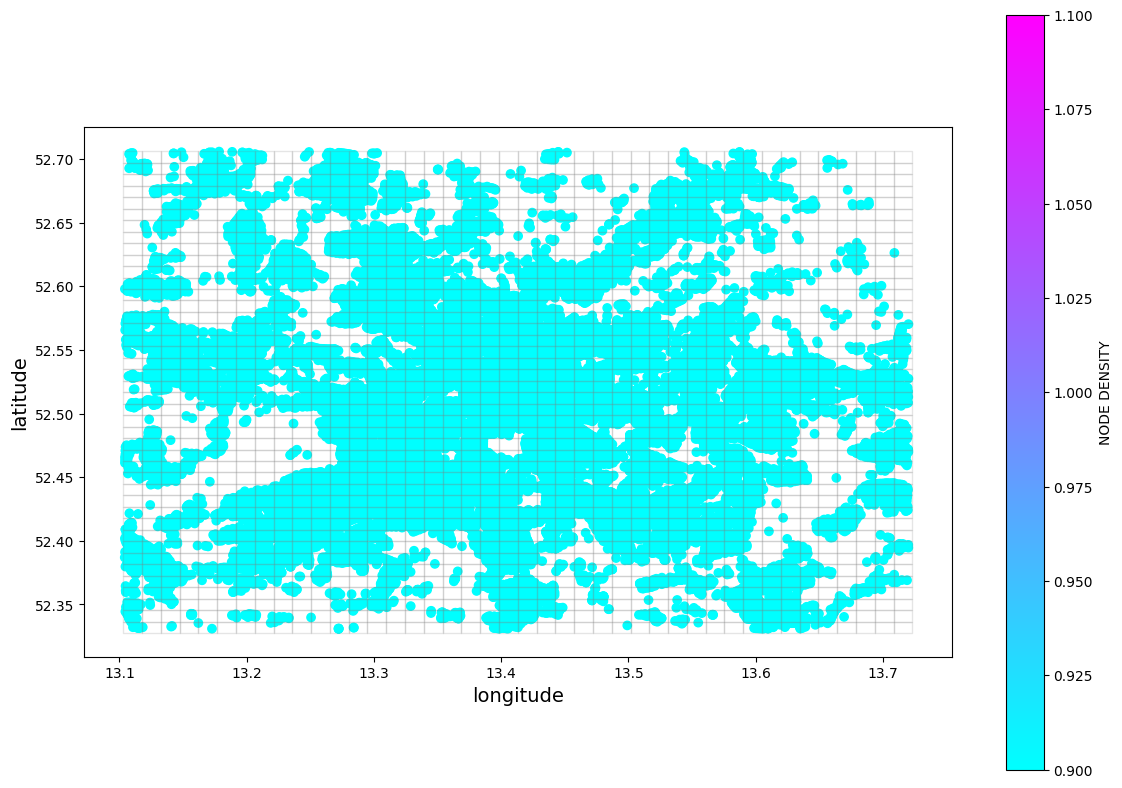

In [14]:
os.chdir(r'C:\Users\mduran\Desktop\PhD- Patterns and Dynamics in Urban Networks\1- DATA POLLUTION - Scaling laws, pdfs\street_network') 

geo_NETWORK_node_dic = {}
merged_NETWORK_node_dic = {}

for city in cities:

    NETWORK_node_dic[city] = NETWORK_node_dic[city].dropna()

    fig, ax = plt.subplots(figsize=(14,14))

    geometry = [Point(xy) for xy in zip(NETWORK_node_dic[city]['x'], NETWORK_node_dic[city]['y'])]

    crs = {'init':'epsg:4326'}

    geo_NETWORK_node_dic[city] = gpd.GeoDataFrame(NETWORK_node_dic[city],
                              crs=crs, #specify our coordinate reference system
                              geometry=geometry)

    geo_NETWORK_node_dic[city] = geo_NETWORK_node_dic[city].drop(columns=['x', 'y'])

    # print(geo_pop_NYC.head())

    geo_NETWORK_node_dic[city].plot(column = 'node', ax= ax, cmap='cool', legend = True, legend_kwds={"label": "NODE DENSITY", "shrink":.7})


    # Use cell_size_lat and cell_size_lon to create the grid
    lat_intermidate_point = (ymin[city] + ymax[city]) / 2
    cell_size_lat = cell_size_meters / 111000  # degrees of latitude per meter
    cell_size_lon = cell_size_meters / (111320 * cos(radians(lat_intermidate_point)))  # degrees of longitude per meter

    n_cells_x = (xmax[city]-xmin[city])/cell_size_lon

    n_cells_y = (ymax[city]-ymin[city])/cell_size_lat
    
    # projection of the grid
    crs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"
    # create the cells in a loop
    grid_cells = []
    for y0 in np.arange(ymax[city], ymin[city], -cell_size_lat):
        for x0 in np.arange(xmin[city], xmax[city], cell_size_lon):
            # Bounds
            x1 = x0 + cell_size_lon
            y1 = y0 - cell_size_lat
            grid_cells.append(shapely.geometry.box(x0, y0, x1, y1))

    merged_NETWORK_node_dic[city] = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs=crs)
    
    merged_NETWORK_node_dic[city].plot(ax=ax, alpha = 0.2, facecolor="none", edgecolor='grey')

    ax.set_xlabel("longitude", fontsize = '14')
    ax.set_ylabel("latitude", fontsize = '14')


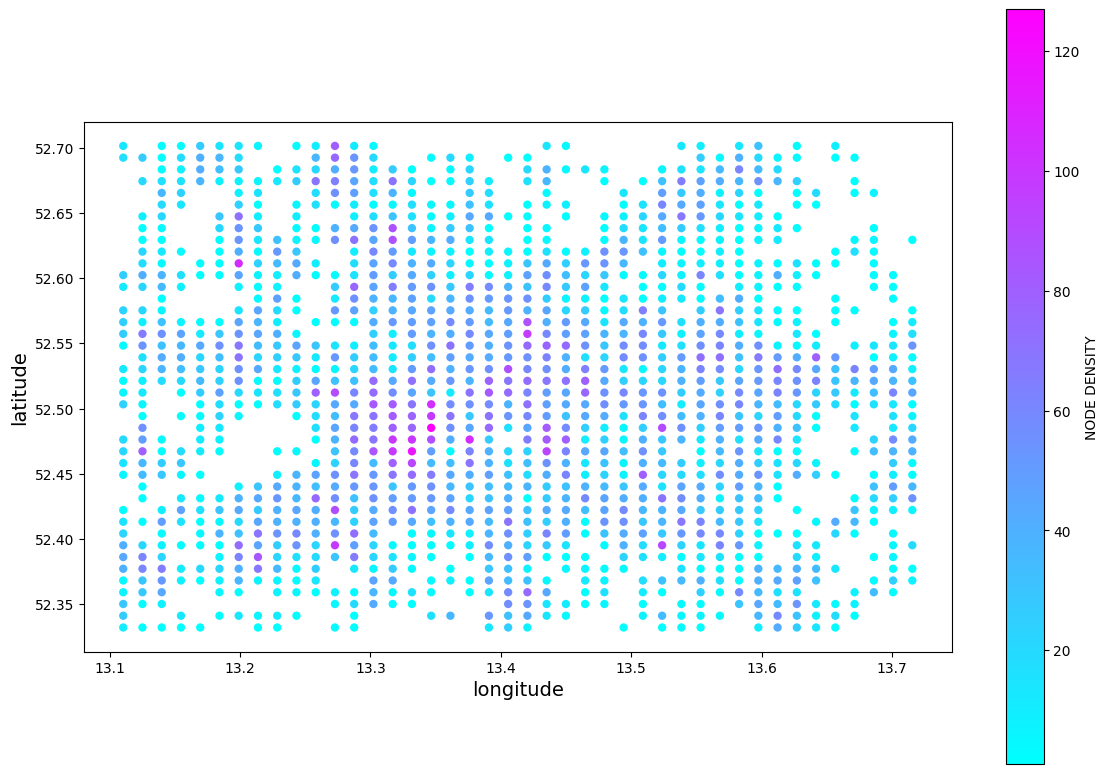

In [15]:
merged_node_dic = {}

for city in cities:
    
    merged_node_dic[city] = gpd.sjoin(geo_NETWORK_node_dic[city], merged_NETWORK_node_dic[city], how='left') #, op='within'

    # BASELINE 
    grouped = merged_node_dic[city].groupby('index_right')['node'].agg(['sum','count']) #'std', 'max','min','mean','sum', lambda x: np.nanmean(x)
    merged_NETWORK_node_dic[city]['node'] = grouped['sum']

    merged_NETWORK_node_dic[city]['geometry'] = merged_NETWORK_node_dic[city]['geometry'].centroid
    
    fig, ax = plt.subplots(figsize=(14,14))

    merged_NETWORK_node_dic[city].plot(ax= ax, column = 'node',alpha=1, linewidth=0, cmap='cool', legend = True, legend_kwds={"label": "NODE DENSITY", "shrink":.7})

    ax.set_xlabel("longitude", fontsize = '14')
    ax.set_ylabel("latitude", fontsize = '14')

In [16]:
os.chdir(r'C:\Users\mduran\Desktop\PhD- Patterns and Dynamics in Urban Networks\1- DATA POLLUTION - Scaling laws, pdfs\RESULTS')

for city in cities:
    merged_NETWORK_node_dic[city]['x'] = merged_NETWORK_node_dic[city]['geometry'].x
    merged_NETWORK_node_dic[city]['y'] = merged_NETWORK_node_dic[city]['geometry'].y

Berlin


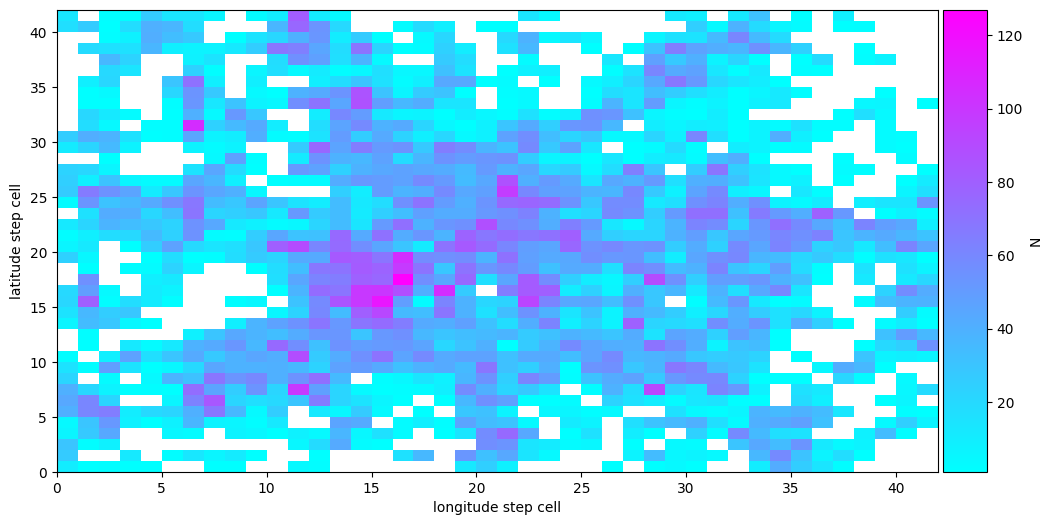

In [17]:
NODEs_dic = {}

for city in cities:

    print(city)
    
    NODEs_dic[city] = merged_NETWORK_node_dic[city]['node']

    merged_NETWORK_node_dic[city]['x'] = merged_NETWORK_node_dic[city]['x'].round(decimals=10)
    merged_NETWORK_node_dic[city]['y'] = merged_NETWORK_node_dic[city]['y'].round(decimals=10)

    total_lat = len(pd.unique(merged_NETWORK_node_dic[city]['y']))
    total_lon = len(pd.unique(merged_NETWORK_node_dic[city]['x']))

    fig, ax = plt.subplots(figsize=(12, 6))

    NODEs_dic[city] = np.reshape(NODEs_dic[city], (total_lat, total_lon))

    NODEs_dic[city] = np.flipud(NODEs_dic[city])

    x = np.linspace(0, total_lon, total_lon + 1)
    y = np.linspace(0, total_lat, total_lat + 1)

    # Replace imshow with pcolormesh
    im = ax.pcolormesh(x, y, NODEs_dic[city], cmap='cool', shading='auto') #copper_r #bone_r #cool #plt.imshow perd qualitat com a vectorized heatmap pero pcolormesh no!

    plt.xlabel('longitude step cell')
    plt.ylabel('latitude step cell')

    # Add colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, label='N', cax=cax)
    
    # plt.savefig(city + '_NODE_heatmap_'+size+'.svg', dpi=1200, bbox_inches="tight")
    
    plt.show()

## POPULATION

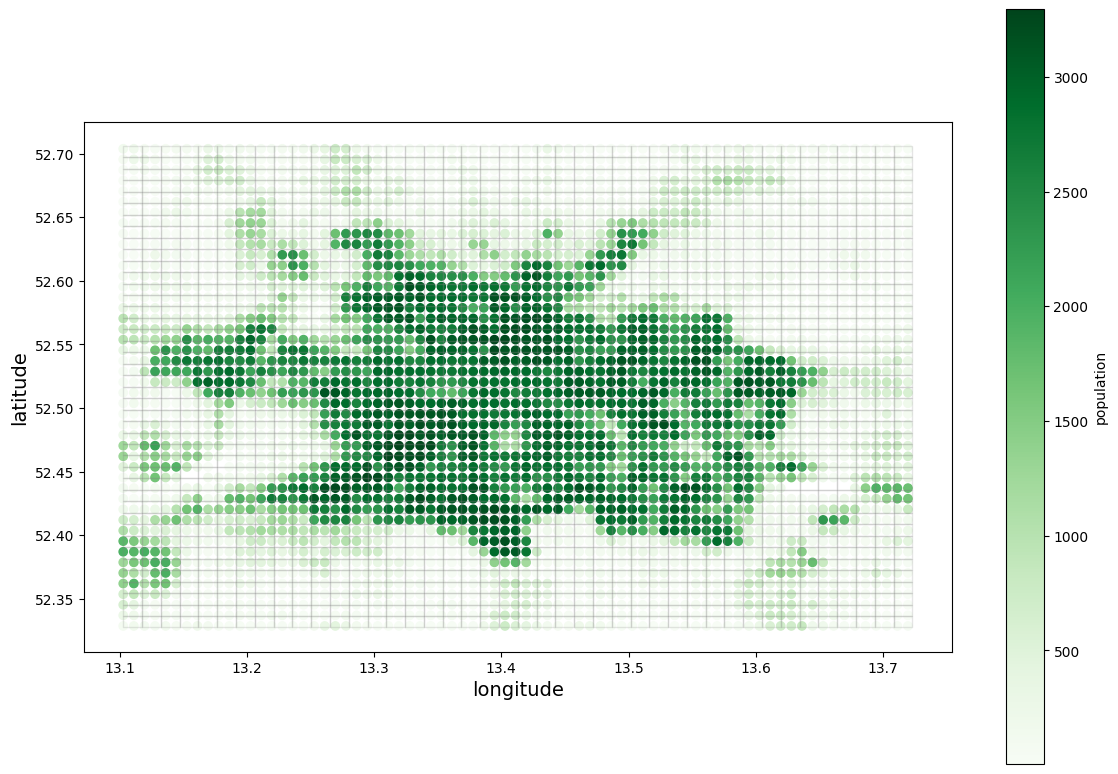

In [18]:
os.chdir(r'C:\Users\mduran\Desktop\PhD- Patterns and Dynamics in Urban Networks\1- DATA POLLUTION - Scaling laws, pdfs') 

geo_pop_dic = {}
merged_pop_dic = {}

for city in cities:

    pop_dic[city] = pop_dic[city].dropna()

    fig, ax = plt.subplots(figsize=(14,14))

    geometry = [Point(xy) for xy in zip(pop_dic[city]['x'], pop_dic[city]['y'])]

    crs = {'init':'epsg:4326'}

    geo_pop_dic[city] = gpd.GeoDataFrame(pop_dic[city], #specify our data
                              crs=crs, #specify our coordinate reference system
                              geometry=geometry) #specify the geometry list we created

    geo_pop_dic[city] = geo_pop_dic[city].drop(columns=['x', 'y'])

    # print(geo_pop_NYC.head())

    geo_pop_dic[city].plot(column = 'population', ax= ax, cmap='Greens', legend = True, legend_kwds={"label": "population", "shrink":.7})


    # Use cell_size_lat and cell_size_lon to create the grid
    lat_intermidate_point = (ymin[city] + ymax[city]) / 2
    cell_size_lat = cell_size_meters / 111000  # degrees of latitude per meter
    cell_size_lon = cell_size_meters / (111320 * cos(radians(lat_intermidate_point)))  # degrees of longitude per meter

    # print(cell_size_lat,cell_size_lon) # --> not the same degree size!
    
    n_cells_x = (xmax[city]-xmin[city])/cell_size_lon
    n_cells_y = (ymax[city]-ymin[city])/cell_size_lat
    # print(n_cells_x,n_cells_y)
    
    # projection of the grid
    crs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"
    # create the cells in a loop
    grid_cells = []
    for y0 in np.arange(ymax[city], ymin[city], -cell_size_lat): #cell_size_temperature
        for x0 in np.arange(xmin[city], xmax[city], cell_size_lon):
            # Bounds
            x1 = x0 + cell_size_lon
            y1 = y0 - cell_size_lat
            grid_cells.append(shapely.geometry.box(x0, y0, x1, y1))

    merged_pop_dic[city] = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs=crs)
    
    merged_pop_dic[city].plot(ax=ax, alpha = 0.2, facecolor="none", edgecolor='grey')


    # x = np.arange(xmin,xmax,0.05)
    # y = np.arange(ymin,ymax,0.05)
    # plt.xticks(x)
    # plt.yticks(y)
    ax.set_xlabel("longitude", fontsize = '14')
    ax.set_ylabel("latitude", fontsize = '14')

    # plt.savefig(city+'_pop_geo_grid100.svg', format='svg', dpi=1200)

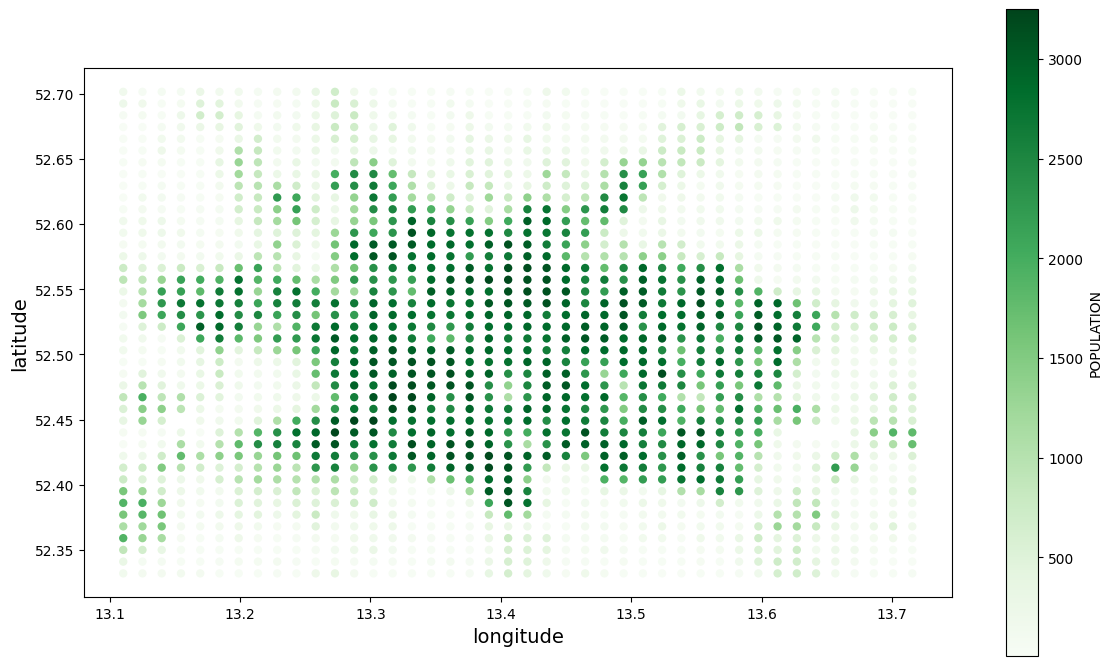

In [19]:
merged_dic = {}

for city in cities:
    
    merged_dic[city] = gpd.sjoin(geo_pop_dic[city], merged_pop_dic[city], how='inner') 
    
    grouped = merged_dic[city].groupby('index_right')['population'].agg(['mean','count']) 
    merged_pop_dic[city]['population'] = grouped['mean']


    merged_pop_dic[city]['geometry'] = merged_pop_dic[city]['geometry'].centroid
    
    fig, ax = plt.subplots(figsize=(14,14))

    merged_pop_dic[city].plot(ax= ax, column = 'population',alpha=1, linewidth=0, cmap='Greens', legend = True, legend_kwds={"label": "POPULATION", "shrink":.6})

    ax.set_xlabel("longitude", fontsize = '14')
    ax.set_ylabel("latitude", fontsize = '14')

    plt.show()

In [20]:
os.chdir(r'C:\Users\mduran\Desktop\PhD- Patterns and Dynamics in Urban Networks\1- DATA POLLUTION - Scaling laws, pdfs\RESULTS')

for city in cities:
    merged_pop_dic[city]['x'] = merged_pop_dic[city]['geometry'].x
    merged_pop_dic[city]['y'] = merged_pop_dic[city]['geometry'].y

Berlin


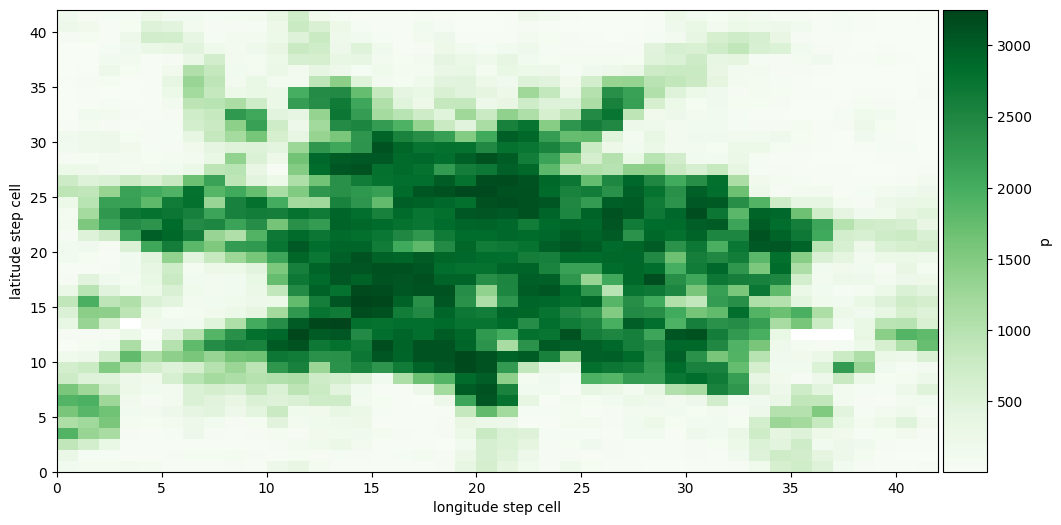

In [21]:
population_dic = {}

for city in cities:

    print(city)
    
    population_dic[city] = merged_pop_dic[city]['population']

    merged_pop_dic[city]['x'] = merged_pop_dic[city]['x'].round(decimals=10)
    merged_pop_dic[city]['y'] = merged_pop_dic[city]['y'].round(decimals=10)

    total_lat = len(pd.unique(merged_pop_dic[city]['y']))
    total_lon = len(pd.unique(merged_pop_dic[city]['x']))

    fig, ax = plt.subplots(figsize=(12, 6))

    population_dic[city] = np.reshape(population_dic[city], (total_lat, total_lon))

    population_dic[city] = np.flipud(population_dic[city])

    x = np.linspace(0, total_lon, total_lon + 1)
    y = np.linspace(0, total_lat, total_lat + 1)

    im = ax.pcolormesh(x, y, population_dic[city], cmap='Greens', shading='auto') 

    plt.xlabel('longitude step cell')
    plt.ylabel('latitude step cell')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, label='p', cax=cax)
        
    plt.show()

## TEMPERATURE

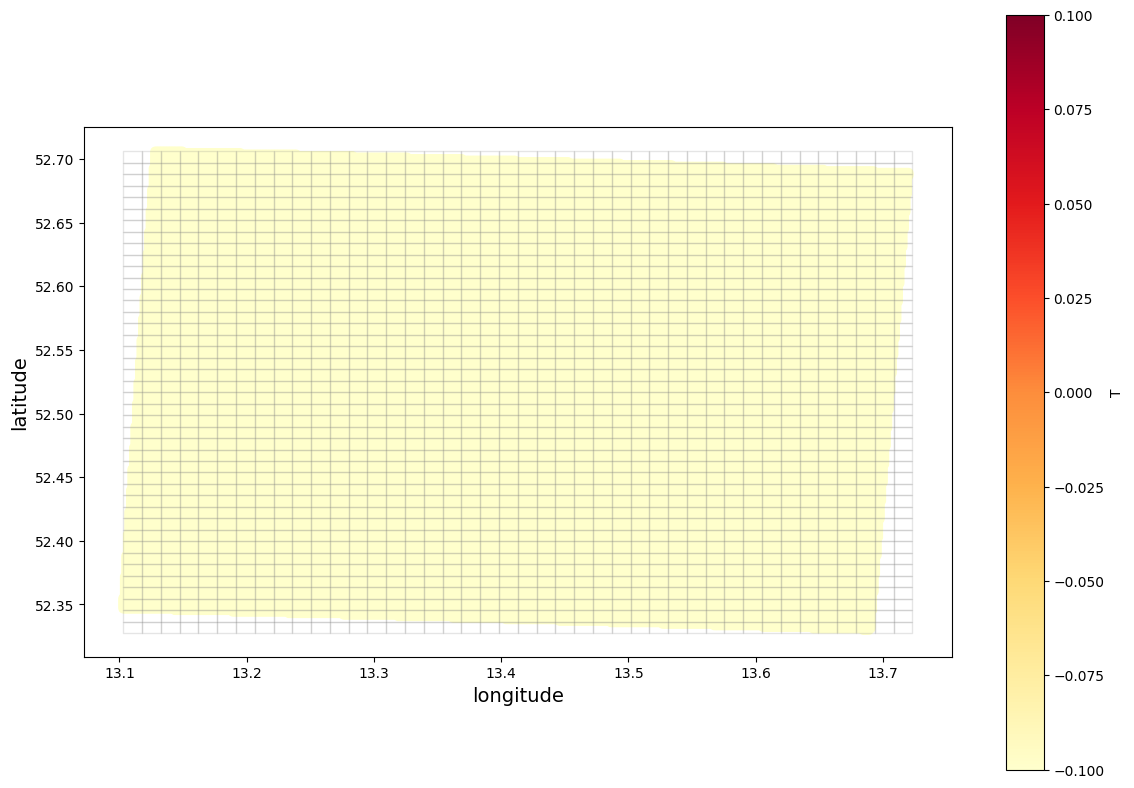

In [22]:
os.chdir(r'C:\Users\mduran\Desktop\PhD- Patterns and Dynamics in Urban Networks\1- DATA POLLUTION - Scaling laws, pdfs\RESULTS\DEF_AIRT_ALL')

geo_T_dic = {}
merged_T_dic = {}

for city in cities:

    T_dic[city] = T_dic[city].dropna()

    fig, ax = plt.subplots(figsize=(14,14))

    geometry = [Point(xy) for xy in zip(T_dic[city]['x'], T_dic[city]['y'])]

    crs = {'init':'epsg:4326'}

    geo_T_dic[city] = gpd.GeoDataFrame(T_dic[city],
                              crs=crs, #specify our coordinate reference system
                              geometry=geometry)

    geo_T_dic[city] = geo_T_dic[city].drop(columns=['x', 'y'])

    geo_T_dic[city].plot(column = 'T', ax= ax, cmap='YlOrRd', legend = True, legend_kwds={"label": "T", "shrink":.7})


    # Use cell_size_lat and cell_size_lon to create the grid
    lat_intermidate_point = (ymin[city] + ymax[city]) / 2
    cell_size_lat = cell_size_meters / 111000  # degrees of latitude per meter
    cell_size_lon = cell_size_meters / (111320 * cos(radians(lat_intermidate_point)))  # degrees of longitude per meter

    n_cells_x = (xmax[city]-xmin[city])/cell_size_lon

    n_cells_y = (ymax[city]-ymin[city])/cell_size_lat
    
    # projection of the grid
    crs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"
    # create the cells in a loop
    grid_cells = []
    for y0 in np.arange(ymax[city], ymin[city], -cell_size_lat): 
        for x0 in np.arange(xmin[city], xmax[city], cell_size_lon):
            # Bounds
            x1 = x0 + cell_size_lon
            y1 = y0 - cell_size_lat
            grid_cells.append(shapely.geometry.box(x0, y0, x1, y1, ccw=True))

    merged_T_dic[city] = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs=crs)
    
    merged_T_dic[city].plot(ax=ax, alpha = 0.2, facecolor="none", edgecolor='grey')


    ax.set_xlabel("longitude", fontsize = '14')
    ax.set_ylabel("latitude", fontsize = '14')

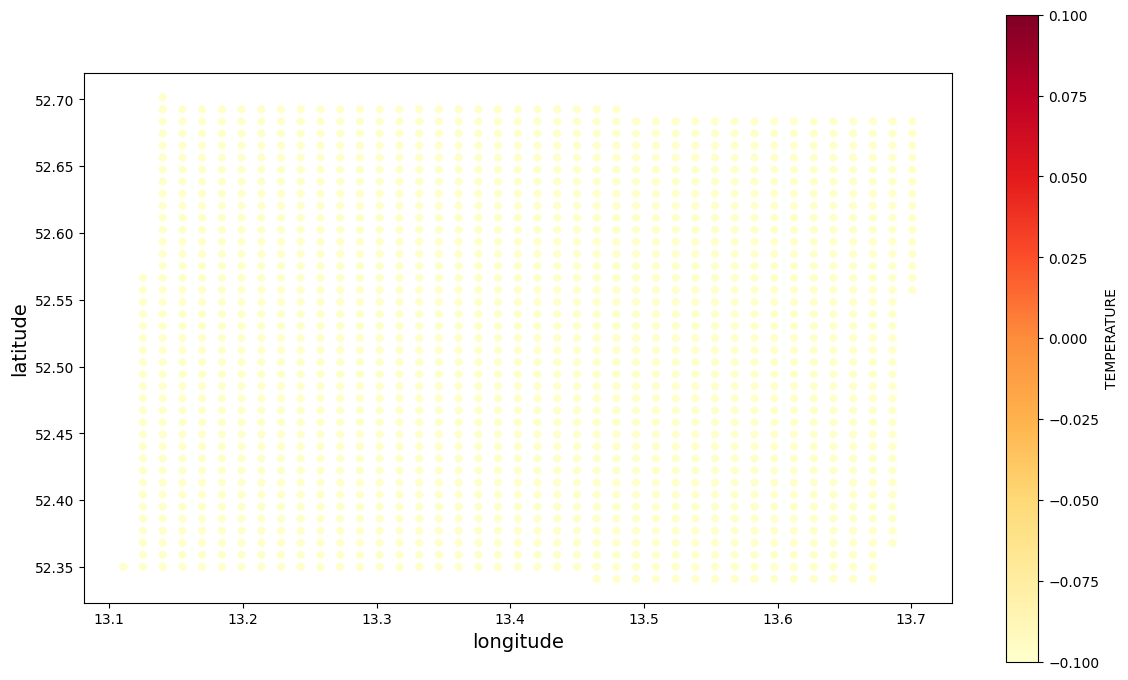

In [23]:

merged_dic = {}

for city in cities:
    
    merged_dic[city] = gpd.sjoin(geo_T_dic[city], merged_T_dic[city], how='left') 

    # BASELINE
    grouped_T = merged_dic[city].groupby('index_right')['T'].agg(['mean','count']) 
    merged_T_dic[city]['T'] = grouped_T['mean']

    
    merged_T_dic[city]['geometry'] = merged_T_dic[city]['geometry'].centroid
    
    fig, ax = plt.subplots(figsize=(14,14))

    merged_T_dic[city].plot(ax= ax, column = 'T',alpha=1, linewidth=0, cmap='YlOrRd', legend = True, legend_kwds={"label": "TEMPERATURE", "shrink":.6})

    ax.set_xlabel("longitude", fontsize = '14')
    ax.set_ylabel("latitude", fontsize = '14')

    plt.show()

In [24]:
os.chdir(r'C:\Users\mduran\Desktop\PhD- Patterns and Dynamics in Urban Networks\1- DATA POLLUTION - Scaling laws, pdfs\RESULTS')

for city in cities:
    merged_T_dic[city]['x'] = merged_T_dic[city]['geometry'].x
    merged_T_dic[city]['y'] = merged_T_dic[city]['geometry'].y

Berlin


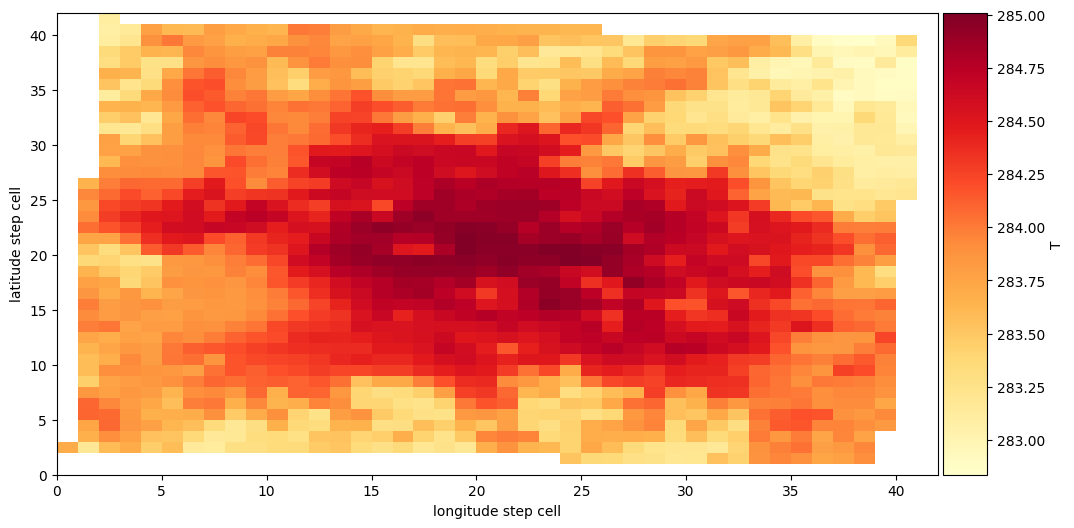

In [25]:
temperature_dic = {}

all_temperatures = np.concatenate([merged_T_dic[city]['T'].dropna().values for city in cities])

vmin = np.min(all_temperatures)
vmax = np.max(all_temperatures)
    

for city in cities:

    print(city)
    
    temperature_dic[city] = merged_T_dic[city]['T']

    merged_T_dic[city]['x'] = merged_T_dic[city]['x'].round(decimals=10)
    merged_T_dic[city]['y'] = merged_T_dic[city]['y'].round(decimals=10)

    total_lat = len(pd.unique(merged_T_dic[city]['y']))
    total_lon = len(pd.unique(merged_T_dic[city]['x']))

    fig, ax = plt.subplots(figsize=(12, 6))

    temperature_dic[city] = np.reshape(temperature_dic[city], (total_lat, total_lon))

    temperature_dic[city] = np.flipud(temperature_dic[city])

    x = np.linspace(0, total_lon, total_lon + 1)
    y = np.linspace(0, total_lat, total_lat + 1)

    # Replace imshow with pcolormesh
    im = ax.pcolormesh(x, y, temperature_dic[city], cmap='YlOrRd', shading='auto') 

    plt.xlabel('longitude step cell')
    plt.ylabel('latitude step cell')

    # Add colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, label='T', cax=cax)

    plt.show()

## PM 2.5

Berlin


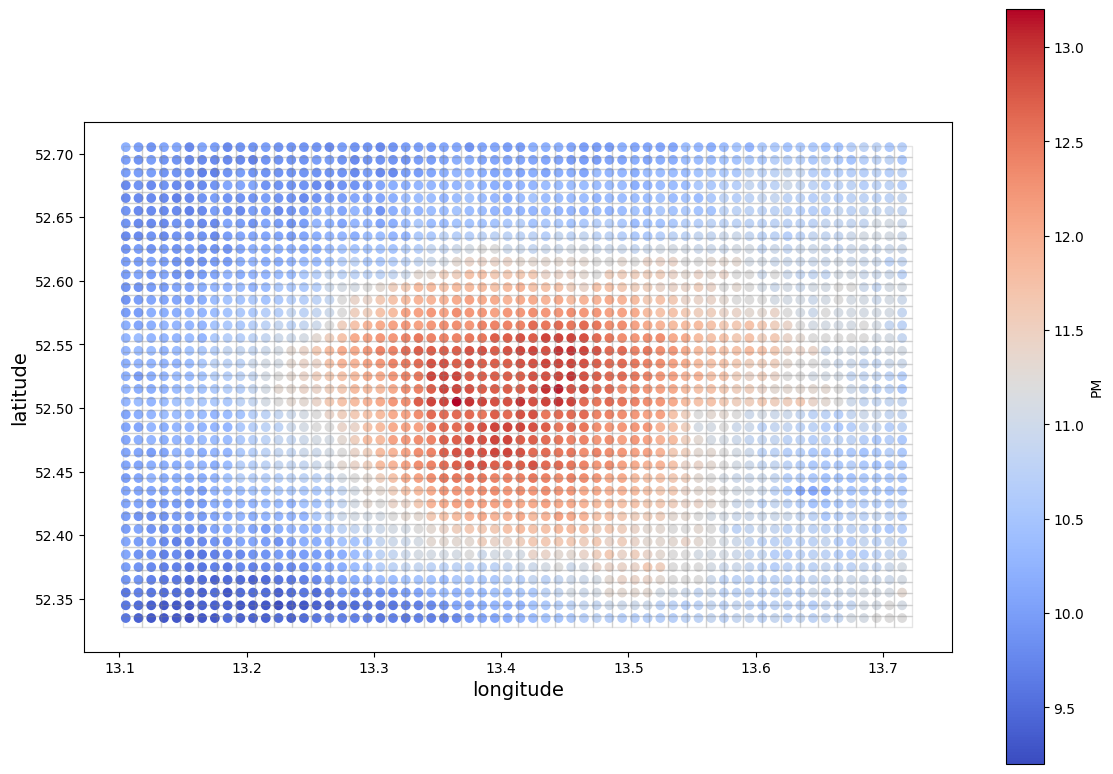

In [26]:
os.chdir(r'C:\Users\mduran\Desktop\PhD- Patterns and Dynamics in Urban Networks\1- DATA POLLUTION - Scaling laws, pdfs') 

PM = '25'

geo_PM_dic = {}
merged_PM_dic = {}

for city in cities:


    PM_dic[city] = PM_dic[city].dropna()

    fig, ax = plt.subplots(figsize=(14,14))

    geometry = [Point(xy) for xy in zip(PM_dic[city]['x'], PM_dic[city]['y'])]

    crs = {'init':'epsg:4326'}

    geo_PM_dic[city] = gpd.GeoDataFrame(PM_dic[city], 
                              crs=crs, #specify our coordinate reference system
                              geometry=geometry)

    geo_PM_dic[city] = geo_PM_dic[city].drop(columns=['x', 'y'])

    geo_PM_dic[city].plot(column = 'PM'+PM, ax= ax, cmap='coolwarm', legend = True, legend_kwds={"label": "PM", "shrink":.7})


    # Use cell_size_lat and cell_size_lon to create the grid
    lat_intermidate_point = (ymin[city] + ymax[city]) / 2
    cell_size_lat = cell_size_meters / 111000  # degrees of latitude per meter
    cell_size_lon = cell_size_meters / (111320 * cos(radians(lat_intermidate_point)))  # degrees of longitude per meter

    # print(cell_size_lat,cell_size_lon) # --> not the same degree size!
    
    n_cells_x = (xmax[city]-xmin[city])/cell_size_lon
    n_cells_y = (ymax[city]-ymin[city])/cell_size_lat
    # print(n_cells_x,n_cells_y)
    
    # projection of the grid
    crs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"
    # create the cells in a loop
    grid_cells = []
    for y0 in np.arange(ymax[city], ymin[city], -cell_size_lat): #cell_size_temperature
        for x0 in np.arange(xmin[city], xmax[city], cell_size_lon):
            # Bounds
            x1 = x0 + cell_size_lon
            y1 = y0 - cell_size_lat
            grid_cells.append(shapely.geometry.box(x0, y0, x1, y1))

    merged_PM_dic[city] = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs=crs)

    print(city)
    merged_PM_dic[city].plot(ax=ax, alpha = 0.2, facecolor="none", edgecolor='grey')

    ax.set_xlabel("longitude", fontsize = '14')
    ax.set_ylabel("latitude", fontsize = '14')
    plt.show()

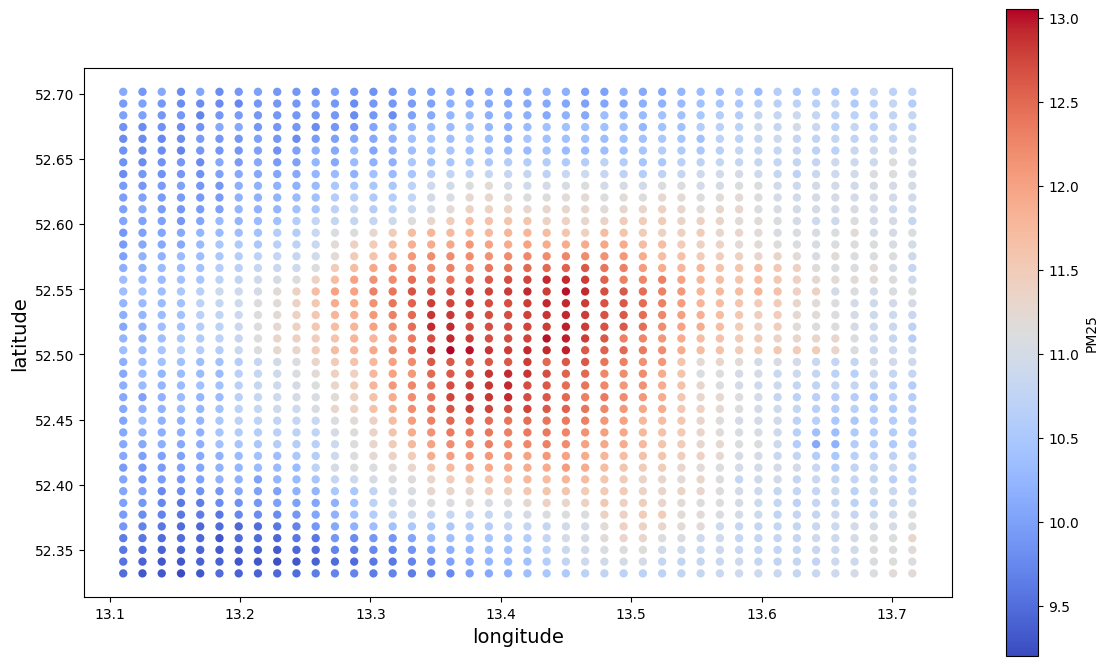

In [27]:

merged_dic = {}

for city in cities:
    
    merged_dic[city] = gpd.sjoin(geo_PM_dic[city], merged_PM_dic[city], how='left')
    
    grouped = merged_dic[city].groupby('index_right')['PM'+PM].agg(['mean','count']) 
    merged_PM_dic[city]['PM'+PM] = grouped['mean']

    merged_PM_dic[city]['geometry'] = merged_PM_dic[city]['geometry'].centroid


    # INTERPOLATION
    
    # Change coordinates
    # merged_PM_dic[city] = merged_PM_dic[city].to_crs(epsg=3857)

    # Extract centroid coordinates and PM values
    grid_coords = np.array([(geom.centroid.x, geom.centroid.y) for geom in  merged_PM_dic[city].geometry])
    pm_values = merged_PM_dic[city]['PM'+PM].values

    # Identify valid and missing data
    valid_mask = ~np.isnan(pm_values)
    missing_mask = np.isnan(pm_values)

    if np.any(missing_mask):
        # Perform interpolation using griddata
        interpolated_values = griddata(
            points=grid_coords[valid_mask],
            values=pm_values[valid_mask],
            xi=grid_coords[missing_mask],
            method='linear'
        )

        # Assign interpolated values to missing cells
        merged_PM_dic[city].loc[missing_mask, 'PM'+PM] = interpolated_values

        # Optional: For any remaining NaNs after linear interpolation, use nearest method
        still_missing = merged_PM_dic[city]['PM'+PM].isna()
        if still_missing.any():
            interpolated_nearest = griddata(
                points=grid_coords[valid_mask],
                values=pm_values[valid_mask],
                xi=grid_coords[still_missing],
                method='linear'#'nearest'
            )
            merged_PM_dic[city].loc[still_missing, 'PM'+PM] = interpolated_nearest

    # Convert back to original CRS
    # merged_PM_dic[city] = merged_PM_dic[city].to_crs('EPSG:4326')
    
    fig, ax = plt.subplots(figsize=(14,14))

    merged_PM_dic[city].plot(ax= ax, column = 'PM'+PM,alpha=1, linewidth=0, cmap='coolwarm', legend = True, legend_kwds={"label": "PM"+PM, "shrink":.6})

    ax.set_xlabel("longitude", fontsize = '14')
    ax.set_ylabel("latitude", fontsize = '14')

    plt.show()


In [28]:
os.chdir(r'C:\Users\mduran\Desktop\PhD- Patterns and Dynamics in Urban Networks\1- DATA POLLUTION - Scaling laws, pdfs\RESULTS')

for city in cities:
    merged_PM_dic[city]['x'] = merged_PM_dic[city]['geometry'].x
    merged_PM_dic[city]['y'] = merged_PM_dic[city]['geometry'].y

Berlin


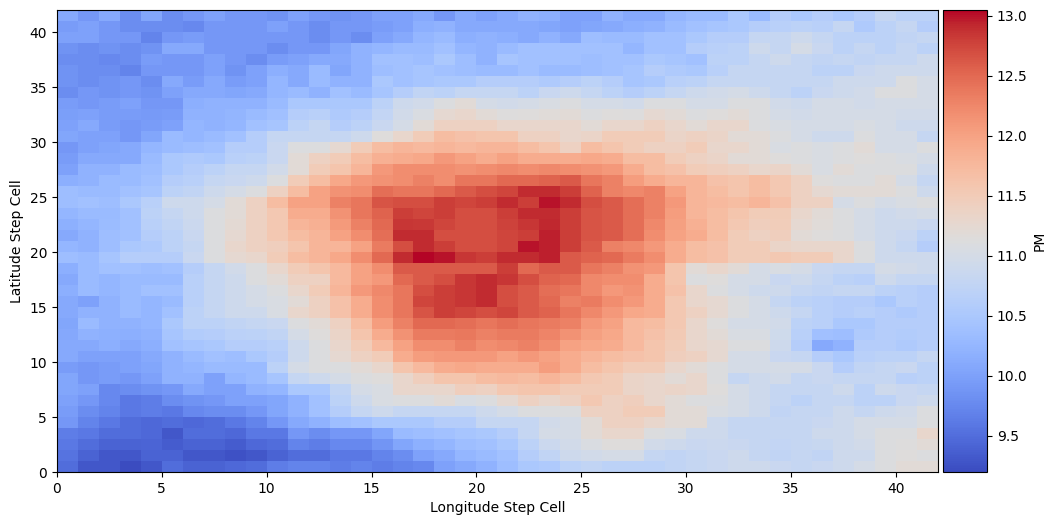

In [29]:
pollution_dic = {}

for city in cities:

    print(city)
    
    pollution_dic[city] = merged_PM_dic[city]['PM' + PM]
    
    merged_PM_dic[city]['x'] = merged_PM_dic[city]['x'].round(decimals=10)
    merged_PM_dic[city]['y'] = merged_PM_dic[city]['y'].round(decimals=10)
    
    total_lat = len(pd.unique(merged_PM_dic[city]['y']))
    total_lon = len(pd.unique(merged_PM_dic[city]['x']))
    
    fig, ax = plt.subplots(figsize=(12, 6))

    pollution_dic[city] = np.reshape(pollution_dic[city], (total_lat, total_lon))

    pollution_dic[city] = np.flipud(pollution_dic[city])
    
    x = np.linspace(0, total_lon, total_lon + 1)
    y = np.linspace(0, total_lat, total_lat + 1)
    
    im = ax.pcolormesh(x, y, pollution_dic[city], cmap='coolwarm', shading='auto')
    
    plt.xlabel('Longitude Step Cell')
    plt.ylabel('Latitude Step Cell')
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, label='PM', cax=cax)

    plt.show()

# GENERATE STREET NETWORK, POPULATION WITH CLIMATE VARIABLES

In [30]:
os.chdir(r'C:\Users\mduran\Desktop\PhD- Patterns and Dynamics in Urban Networks\1- DATA POLLUTION - Scaling laws, pdfs\RESULTS_GLOBAL') 

for city in cities:
    merged_pop_dic[city] = merged_pop_dic[city].drop(columns=['geometry'])
    merged_PM_dic[city] = merged_PM_dic[city].drop(columns=['geometry'])
    merged_T_dic[city] = merged_T_dic[city].drop(columns=['geometry'])
    merged_NETWORK_node_dic[city] = merged_NETWORK_node_dic[city].drop(columns=['geometry'])
    
    merged_PM_dic[city] = merged_PM_dic[city].drop(columns=['x'])
    merged_T_dic[city] = merged_T_dic[city].drop(columns=['x'])
    merged_NETWORK_node_dic[city] = merged_NETWORK_node_dic[city].drop(columns=['x'])

    merged_PM_dic[city] = merged_PM_dic[city].drop(columns=['y'])
    merged_T_dic[city] = merged_T_dic[city].drop(columns=['y'])
    merged_NETWORK_node_dic[city] = merged_NETWORK_node_dic[city].drop(columns=['y'])
    
    merged_pop_dic[city] = merged_pop_dic[city].reset_index(drop=True)
    merged_PM_dic[city] = merged_PM_dic[city].reset_index(drop=True)
    merged_T_dic[city] = merged_T_dic[city].reset_index(drop=True)
    merged_NETWORK_node_dic[city] = merged_NETWORK_node_dic[city].reset_index(drop=True)

In [31]:
# MERGE T AND POPULATION 

os.chdir(r'C:\Users\mduran\Desktop\PhD- Patterns and Dynamics in Urban Networks\1- DATA POLLUTION - Scaling laws, pdfs\RESULTS_GLOBAL') 

T_PM_dic = {}
T_PM_NETWORK_dic = {}
pop_T_PM_NETWORK_dic = {}


for city in cities:
    T_PM_dic[city] = pd.concat([merged_T_dic[city], merged_PM_dic[city]], axis=1)
    T_PM_NETWORK_dic[city] = pd.concat([T_PM_dic[city], merged_NETWORK_node_dic[city]], axis=1)
    pop_T_PM_NETWORK_dic[city] = pd.concat([T_PM_NETWORK_dic[city], merged_pop_dic[city]], axis=1) 
    
    pop_T_PM_NETWORK_dic[city].to_csv(city+'_pop_T'+temperature+'_PM'+PM+'_NETWORK_'+size+'_2.csv', index=False)

In [32]:
for city in cities:

    pop_T_PM_NETWORK_dic[city].replace([np.inf, -np.inf], np.nan, inplace=True)

    pop_T_PM_NETWORK_dic[city] = pop_T_PM_NETWORK_dic[city].dropna().reset_index(drop=True) 

In [33]:
pop_T_PM_NETWORK_dic[city]

,T,PM25,node,population,x,y
0,283.108344,10.10,2.0,78.934586,13.139907,52.701457
1,283.089747,9.90,1.0,20.287106,13.139907,52.692448
2,283.155507,9.80,18.0,89.675766,13.154670,52.692448
3,283.772448,9.80,40.0,508.072906,13.169432,52.692448
4,283.607992,9.80,37.0,451.672058,13.184194,52.692448
...,...,...,...,...,...,...
1252,283.955999,10.75,59.0,718.053589,13.612304,52.341097
1253,283.893630,10.80,31.0,684.109985,13.627067,52.341097
1254,283.751229,10.75,7.0,414.545624,13.641829,52.341097
1255,283.771050,10.90,18.0,212.876373,13.656591,52.341097
